INITIALIZING DATA PROCESSING + CLEANING

 DATA PROCESSING + CLEANING COMPLETE 

INITIALIZING DATA ANALYSIS
The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results. 
 If you have not used it before, it may take a while to download as it is quite large. 

['covid', 'negative', 'positive']


APPRPOVED, INITALIZING TWEET ANALYSIS 

['covid', 'negative', 'positive']


  2%|▏         | 1/50 [00:00<00:22,  2.19it/s]

b'$7
['negative', 'positive', 'covid']
[0.9872449040412903, 0.38887280225753784, 0.3649911880493164]




  4%|▍         | 2/50 [00:01<00:33,  1.44it/s]

b'news: the efl say 25% of players are not vaccinated against covid kmfmnews 
['negative', 'covid', 'positive']
[0.7195845246315002, 0.6063669919967651, 0.0031882126349955797]




  6%|▌         | 3/50 [00:02<00:34,  1.38it/s]

b'covid: action needed to limit hospital admissions - sage scientists 
['covid', 'negative', 'positive']
[0.6725738048553467, 0.5269215106964111, 0.23183830082416534]




  8%|▊         | 4/50 [00:02<00:33,  1.37it/s]

b"meanwhile in ireland covid virus is very dangerous after 8pm
['covid', 'negative', 'positive']
[0.8465135097503662, 0.3293897211551666, 0.0014746924862265587]




 10%|█         | 5/50 [00:05<01:12,  1.61s/it]

b'triple vaccinated \xf0\x9f\xa6\xb8\xf0\x9f\x8f\xbb\xe2\x80\x8d\xe2\x99\x80\xef\xb8\x8f\xf0\x9f\x92\xaa  feeling the power growing in my veins \xf0\x9f\xa4\xaa\xf0\x9f\x99\x88  getvaccinated vaccinated covid'
['covid', 'positive', 'negative']
[0.964379608631134, 0.8170974850654602, 0.15723785758018494]




 12%|█▏        | 6/50 [00:07<01:03,  1.45s/it]

b"la's also playing the omicrondeltablues: los angeles county is seeing the highest number of daily covid-19 cases in four months
['covid', 'negative', 'positive']
[0.7596291899681091, 0.6154252886772156, 0.0013315402902662754]




 14%|█▍        | 7/50 [00:08<01:00,  1.40s/it]

b'omicron covid i\xe2\x80\x99ve just been told by testandtrace that if it is the omicron variant that they will contact you twice
['covid', 'positive', 'negative']
[0.9850179553031921, 0.044962212443351746, 0.03229398652911186]




 16%|█▌        | 8/50 [00:09<00:59,  1.41s/it]

b'it is so unfortunate that this is going to happen as we head into the third winter of covid however we must think about what these rapidly rising cases not just do to patients but to our healthcare systems and staff. 
['negative', 'covid', 'positive']
[0.950545608997345, 0.9074780941009521, 0.00018227043619845062]




 18%|█▊        | 9/50 [00:11<01:01,  1.51s/it]

b'paddy power in his d4 jumper \xe2\x80\x9ci\xe2\x80\x99ve had more vaccines than nights out\xe2\x80\x9d\xc2\xa0covid-19 
['covid', 'negative', 'positive']
[0.9234002828598022, 0.20050708949565887, 0.13461603224277496]




 20%|██        | 10/50 [00:12<00:52,  1.31s/it]

b'a bit like all the fear and hysteria being whipped up about covid and vacinnepassports
['negative', 'covid', 'positive']
[0.8795966506004333, 0.02851164899766445, 0.0006847357144579291]




 22%|██▏       | 11/50 [00:13<00:44,  1.15s/it]

b'no sh covid is seasonal, who could have know??? srcsm 
['covid', 'negative', 'positive']
[0.6959219574928284, 0.16626030206680298, 0.0015627957182005048]




 24%|██▍       | 12/50 [00:14<00:44,  1.16s/it]

b'give us your best covid christmas carols:  omicron all ye faithful oh lateral flow of bethlehem  anothercovidchristmas'
['covid', 'positive', 'negative']
[0.7891451716423035, 0.13971634209156036, 0.0010127630084753036]




 26%|██▌       | 13/50 [00:14<00:34,  1.06it/s]

b'save lives
['positive', 'covid', 'negative']
[0.9482944011688232, 0.04351169988512993, 0.0012351786717772484]




 28%|██▊       | 14/50 [00:15<00:32,  1.09it/s]

b'the national football league (nfl) postponed three games this weekend because of covid-19 outbreaks
['negative', 'covid', 'positive']
[0.767952561378479, 0.3837144374847412, 0.012505458667874336]




 30%|███       | 15/50 [00:16<00:29,  1.19it/s]

b'at some point, these folks should end up in jail
['negative', 'covid', 'positive']
[0.969681978225708, 0.899877667427063, 0.0004092130111530423]




 32%|███▏      | 16/50 [00:17<00:34,  1.00s/it]

b'remember: if you\xe2\x80\x99re wearing a facecovering, covid can\xe2\x80\x99t enter your body via your chin
['covid', 'negative', 'positive']
[0.6272400617599487, 0.11220719665288925, 0.013358215801417828]




 34%|███▍      | 17/50 [00:19<00:37,  1.14s/it]

b'now is the time to get your booster vaccine and get into a routine of daily vitamin intake - covid omicron flu publichealth healthcare nhs\xf0\x9f\x92\x99 
['covid', 'positive', 'negative']
[0.5975480675697327, 0.03787647932767868, 0.007845061831176281]




 36%|███▌      | 18/50 [00:19<00:32,  1.01s/it]

b'"huge numbers of people getting sick all at once will alter everyday reality
['covid', 'negative', 'positive']
[0.5273126363754272, 0.4724225699901581, 0.009211105294525623]




 38%|███▊      | 19/50 [00:20<00:30,  1.03it/s]

b'3 dead in karachi blast  covid internationalnews newsfeed breakingnews breaking wewantjustice'
['covid', 'negative', 'positive']
[0.9800358414649963, 0.20018421113491058, 0.001947790035046637]




 40%|████      | 20/50 [00:21<00:27,  1.10it/s]

b'morrison is like the tinman without a heart in the wizard of oz
['negative', 'covid', 'positive']
[0.5216024518013, 0.005605234298855066, 0.00024985760683193803]




 42%|████▏     | 21/50 [00:23<00:32,  1.12s/it]

b'imo | with 800,000 lost souls and doubling infection rates in the us,  (or anyone else) should not devote 6:00 to how covid is "affecting sports schedules" ffs  it\'s macabre'
['negative', 'covid', 'positive']
[0.9572349190711975, 0.6015805602073669, 0.00015816176892258227]




 44%|████▍     | 22/50 [00:24<00:30,  1.09s/it]

b'could be how covid extends its life cycle and hopefully be how we are able to move forward with it as part of our lives
['covid', 'positive', 'negative']
[0.9981465935707092, 0.89972323179245, 0.0004605871217790991]




 46%|████▌     | 23/50 [00:26<00:36,  1.35s/it]

b'remember folks, best before dates on casks & kegs are just that, beer will be tasting good for a heck of a lot longer in the vast amount of cases, but if the shit hits the covid-fan please talk to us about uplifting any full casks we may have just delivered.'
['covid', 'positive', 'negative']
[0.5788227915763855, 0.0535288080573082, 0.033605389297008514]




 50%|█████     | 25/50 [00:27<00:26,  1.04s/it]

b'fuck this shit
['negative', 'covid', 'positive']
[0.9989700317382812, 0.14620840549468994, 0.00044832570711150765]




 52%|█████▏    | 26/50 [00:28<00:24,  1.01s/it]

b'with surge in omicron cases, covid 3rd wave imminent, says director of odisha public health
['covid', 'negative', 'positive']
[0.6086621880531311, 0.38159725069999695, 0.002602308290079236]




 58%|█████▊    | 29/50 [00:31<00:19,  1.06it/s]

b'economicimpact of covid-19 has been much sharper than that of global financial crisis
['covid', 'positive', 'negative']
[0.8690195679664612, 0.5821420550346375, 0.35303884744644165]




 60%|██████    | 30/50 [00:33<00:23,  1.20s/it]

b'for what it\xe2\x80\x99s worth at least ppl can\xe2\x80\x99t point fingers at the germans for letting hitler happen\xe2\x80\xa6  covid technocracy totalitarismo'
['covid', 'negative', 'positive']
[0.9589369297027588, 0.7441347241401672, 0.01687445677816868]




 64%|██████▍   | 32/50 [00:38<00:32,  1.79s/it]

b'southafrica before covid 
['covid', 'negative', 'positive']
[0.9166768193244934, 0.4052331745624542, 0.140796959400177]




 66%|██████▌   | 33/50 [00:39<00:25,  1.52s/it]

b'taylorswift album party becomes superspreader event after nearly 100 test positive for covid 
['covid', 'positive', 'negative']
[0.6925788521766663, 0.45966580510139465, 0.002540994668379426]




 68%|██████▊   | 34/50 [00:40<00:21,  1.35s/it]

b'can people post link on (studys) that shows that covid vaccins works and are unharm/safe
['covid', 'positive', 'negative']
[0.9574942588806152, 0.8832091093063354, 0.0008912927587516606]




 70%|███████   | 35/50 [00:41<00:19,  1.31s/it]

b'trying to dodge the covid wildfire 1 week before christmas is really starting to feel like a real-life squid game squidgame omicron covid london christmas 
['covid', 'negative', 'positive']
[0.8132145404815674, 0.40417978167533875, 0.0003528962843120098]




 72%|███████▏  | 36/50 [00:42<00:17,  1.23s/it]

bthey have security guards telling people to remove masks in a massive covid omicron outbreak??  what the actual fuck is this????'
['covid', 'negative', 'positive']
[0.9468275904655457, 0.9242063164710999, 0.00035561411641538143]




 78%|███████▊  | 39/50 [00:44<00:08,  1.35it/s]

bi agree
['covid', 'positive', 'negative']
[0.5203487277030945, 0.48360177874565125, 0.04662061482667923]




 86%|████████▌ | 43/50 [00:47<00:05,  1.26it/s]

b'asked wombo for some art to commemorate my covid booster
['covid', 'positive', 'negative']
[0.8758122324943542, 0.7152925729751587, 0.0014434399781748652]




 88%|████████▊ | 44/50 [00:48<00:05,  1.09it/s]

b" france has got le hump again   own up, whoever's been playing silly buggers, by referring to the covid variant as omacron  
['covid', 'negative', 'positive']
[0.5744082927703857, 0.4953916370868683, 0.00820804201066494]




 90%|█████████ | 45/50 [00:49<00:04,  1.10it/s]

b'vaccine mandate blocked in texas  covid-19 texas vaccinemandates'
['covid', 'negative', 'positive']
[0.9494955539703369, 0.9016531705856323, 0.01769718900322914]




 92%|█████████▏| 46/50 [00:51<00:04,  1.02s/it]

b" france has got le hump again   own up, whoever's been playing silly buggers, by referring to the covid variant as omacron?  
['covid', 'negative', 'positive']
[0.569758951663971, 0.41387471556663513, 0.0025909736286848783]




 94%|█████████▍| 47/50 [00:52<00:03,  1.01s/it]

b'christmas in the workhouse \xf0\x9f\xa5\xb2 fuck covid covid 
['covid', 'negative', 'positive']
[0.9715936779975891, 0.9703925848007202, 0.0005317174945957959]




 96%|█████████▌| 48/50 [00:52<00:01,  1.03it/s]

b'if you have already had your covid-19 booster, please encourage your family and friends to get boosted
['positive', 'covid', 'negative']
[0.8427850604057312, 0.46451762318611145, 0.0029517137445509434]




 98%|█████████▊| 49/50 [00:54<00:01,  1.06s/it]

b'the vaccine rule for private employers is separate from other vaccine mandates announced by the biden administration that apply to federal government contractors and workers in health care facilities   news covid politics'
['covid', 'negative', 'positive']
[0.8688329458236694, 0.11951412260532379, 0.10715083032846451]




100%|██████████| 50/50 [00:56<00:00,  1.13s/it]

b'pre-flight covid testing a dizzying mess? let  help you wade through with our "booking concierge\xe2\x80\x9d service  travel covid covidtesting pcrtest delta businesstravelers travelinsurance hotels airbnb cybersecurity medtech jandj japan jabs 
['covid', 'negative', 'positive']
[0.9501838088035583, 0.1465270072221756, 0.10073447972536087]




<AxesSubplot:xlabel='labels', ylabel='values'>

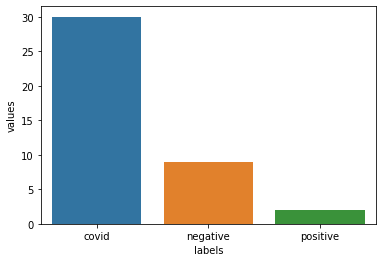

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import html
import re
from transformers import pipeline
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BartTokenizer, BartModel
from transformers import pipeline

print('INITIALIZING DATA PROCESSING + CLEANING')

try:
    user_csv = input('Please input the exact name of the CSV file you wish to analyze: ')
    tweet_column = input('Please input the name of the column containing the tweets: ')
    tweet_column_with_quotes = "'" + tweet_column + "'"

    dataframe = pd.read_csv(user_csv, delimiter=',',encoding='utf-8', header = 0)
    pd.set_option('display.max_colwidth', None)
    dataframe.rename(columns={tweet_column:'tweet'}) #renaming the tweet column to 'tweet'

except FileNotFoundError:
    print('There was an error finding the CSV you requested, please check the following:','\n', '1. The CSV file is in the correct directory', '\n', '2. You gave the correct name of the file, following the syntax: yourfilename.csv')


df_copy = dataframe.copy() #creating a copy of the dataframe
df_copy['tweet'] = df_copy['tweet'].str.lower() #making everything lower case
df_copy.drop_duplicates(subset='tweet', keep='first', inplace=True, ignore_index=False) #removing duplicates
df_copy[~df_copy.tweet.str.startswith('rt')] #removing retweets
df_copy['tweet'] = df_copy['tweet'].apply(lambda k: html.unescape(str(k))) #removing unnecessary characters

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'\...+', '', text) #Remove dots
    text = re.sub(r'\!', '', text) #Remove exclamation  marks

    return text

df_copy['tweet'] = df_copy['tweet'].apply(clean_text)

df_copy.to_csv('Cleaned_Data.csv')

print('\n','DATA PROCESSING + CLEANING COMPLETE', '\n')
print('INITIALIZING DATA ANALYSIS')

print('The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results.', '\n', 'If you have not used it before, it may take a while to download as it is quite large.','\n')

model = input('If you wish to use Bart Large instead, type y.')

if model == 'y':
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')
else:
    tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
    model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1", device = -1)

try:
    classifier = pipeline("zero-shot-classification", model = model, tokenizer = tokenizer, device = -1) #classifier = pipeline(task='zero-shot-classification', model=model, tokenizer=tokenizer, framework='pt')
except RuntimeError:
    print("A runtime error occurred, check if tensorflow and pytorch are correctly installed, need to be version >= 2")

df_original  = pd.read_csv(r'Cleaned_Data.csv')
rows = df_original['tweet'].count()

try:
    number_of_rows = int(input(f'Please specify the number of rows you wish to analyze, in your current dataset, there are {rows} rows of tweets, if you wish to look at them all, input any non-numerical character'))
    df_name = df_original.head(number_of_rows)
except ValueError:
    df_name = df_original

candidate_labels = []
candidate_results = []

def approval():
    candidate_labels = []
    labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')

    while labels != 'done':
        candidate_labels.append(labels)
        labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')
    
    print(f'{candidate_labels}')
    print('\n')
    approved = input('Are these labels correct? if so, type "y", if not, type any other character')

    if approved != "y":
        approval()
    else:
        print('APPRPOVED, INITALIZING TWEET ANALYSIS', '\n')
    return candidate_labels

candidate_labels = approval()
print(candidate_labels)

for x in range(len(candidate_labels)):
    candidate_results.append(0)

for sent in tqdm(df_name['tweet'].values):
        
    res = classifier(sent, candidate_labels, multi_label = True) #change multilabel to True for different results

    for i in range(len(candidate_labels)):
      if res['labels'][0] == candidate_labels[i] and res['scores'][0] > 0.5:
          candidate_results[i] = candidate_results[i] + 1

    if res['scores'][0] > 0.5: #the code below this can be removed if you do not wish to have all of the results printed (might be useful for when the program is actually implemented)
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print('\n')

data = {'labels': candidate_labels, 'values': candidate_results}
df_frequency = pd.DataFrame(data, columns=['labels', 'values'])
df_frequency.head()
sns.barplot(data = df_frequency, x = 'labels', y = 'values')

In [20]:
#THIS VERSION IS NOT FUNCITONING CORRECTLY

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import html
import re
from transformers import pipeline
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BartTokenizer, BartModel
from transformers import pipeline

print('INITIALIZING DATA PROCESSING + CLEANING')

try:
    user_csv = input('Please input the exact name of the CSV file you wish to analyze: ')
    tweet_column = input('Please input the name of the column containing the tweets: ')
    tweet_column_with_quotes = "'" + tweet_column + "'"

    dataframe = pd.read_csv(user_csv, delimiter=',',encoding='utf-8', header = 0)
    pd.set_option('display.max_colwidth', None)
    print(dataframe)
    dataframe.rename({tweet_column_with_quotes:'tweet'}, axis = 1, inplace = True) #why the fuck doesn't renaming this actually work?!?!? it's pissing me off
    print(dataframe)
    
except FileNotFoundError:
    print('There was an error finding the CSV you requested, please check the following:','\n', '1. The CSV file is in the correct directory', '\n', '2. You gave the correct name of the file, following the syntax: yourfilename.csv')


df_copy = dataframe.copy() #creating a copy of the dataframe
df_copy['tweet'] = df_copy['tweet'].str.lower() #making everything lower case
print(df_copy['tweet'])
df_copy.drop_duplicates(subset='tweet', keep='first', inplace=True, ignore_index=False) #removing duplicates
df_copy[~df_copy.tweet.str.startswith('rt')] #removing retweets
df_copy['tweet'] = df_copy['tweet'].apply(lambda k: html.unescape(str(k))) #removing unnecessary characters

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'\...+', '', text) #Remove dots
    text = re.sub(r'\!', '', text) #Remove exclamation  marks

    return text

df_copy['tweet'] = df_copy['tweet'].apply(clean_text)

df_copy.to_csv('Cleaned_Data.csv')

print('\n','DATA PROCESSING + CLEANING COMPLETE', '\n')
print('INITIALIZING DATA ANALYSIS')

print('The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results.', '\n', 'If you have not used it before, it may take a while to download as it is quite large.','\n')

model = input('If you wish to use Bart Large instead, type y.')

if model == 'y':
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')
else:
    tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
    model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1", device = -1)

try:
    classifier = pipeline("zero-shot-classification", model = model, tokenizer = tokenizer, device = -1) #classifier = pipeline(task='zero-shot-classification', model=model, tokenizer=tokenizer, framework='pt')
except RuntimeError:
    print("A runtime error occurred, check if tensorflow and pytorch are correctly installed, need to be version >= 2")

df_original  = pd.read_csv(r'Cleaned_Data.csv')
rows = df_original['tweet'].count()

try:
    number_of_rows = int(input(f'Please specify the number of rows you wish to analyze, in your current dataset, there are {rows} rows of tweets, if you wish to look at them all, input any non-numerical character'))
    df_name = df_original.head(number_of_rows)
except ValueError:
    df_name = df_original

candidate_labels = []
candidate_results = []

def approval():
    candidate_labels = []
    labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')

    while labels != 'done':
        candidate_labels.append(labels)
        labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')
    
    print(f'{candidate_labels}')
    print('\n')
    approved = input('Are these labels correct? if so, type "y", if not, type any other character')

    if approved != "y":
        approval()
    else:
        print('APPRPOVED, INITALIZING TWEET ANALYSIS', '\n')
    return candidate_labels

candidate_labels = approval()
print(candidate_labels)

for x in range(len(candidate_labels)):
    candidate_results.append(0)

for sent in tqdm(df_name['tweet'].values):
        
    res = classifier(sent, candidate_labels, multi_label = True) #change multilabel to True for different results

    for i in range(len(candidate_labels)):
      if res['labels'][0] == candidate_labels[i] and res['scores'][0] > 0.5:
          candidate_results[i] = candidate_results[i] + 1

    if res['scores'][0] > 0.5: #the code below this can be removed if you do not wish to have all of the results printed (might be useful for when the program is actually implemented)
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print('\n')

data = {'labels': candidate_labels, 'values': candidate_results}
df_frequency = pd.DataFrame(data, columns=['labels', 'values'])
df_frequency.head()
sns.barplot(data = df_frequency, x = 'labels', y = 'values')


INITIALIZING DATA PROCESSING + CLEANING
                     timestamp          location  \
0    2021-12-18 10:50:01+00:00               NaN   
1    2021-12-18 10:50:00+00:00          Kent, UK   
2    2021-12-18 10:48:18+00:00   Česká republika   
3    2021-12-18 10:48:12+00:00               NaN   
4    2021-12-18 10:48:00+00:00     London, Paris   
..                         ...               ...   
495  2021-12-18 08:12:48+00:00     United States   
496  2021-12-18 08:12:17+00:00   Los Angeles, CA   
497  2021-12-18 08:11:36+00:00      Here and Now   
498  2021-12-18 08:11:16+00:00   Bangalore India   
499  2021-12-18 08:11:00+00:00  Faaborg, Denmark   

                                                                                                                                                                                                                                                                                                                                               

KeyError: 'tweet'